# Jamaican House Price Prediction Model: 

## My goal is to accurately predict house prices based on no. bedrooms, no. bathrooms, location and size.

### Firstly, I will conduct some EDA:

#### Load data:

In [44]:
!pip install -U pandas-profiling[notebook]

In [40]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [1]:
#import libraries
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sb
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
#read csv file
df = pd.read_csv('alllistings - fixed (3).csv')
df

,Address,List/Rent Price,Region,BR,BTH
0,7.5 LOMBARD CLOSE,527587.0,6,3.0,2.0
1,LOT #17 MAVERLEY MOUNTAI...,6000000.0,100,NaN,NaN
2,LOT #18 MAVERLEY MOUNTAI...,6500000.0,100,NaN,NaN
3,LOT #12 MAVERLEY MOUNTAI...,7500000.0,100,NaN,NaN
4,Lot 92 COOPERS HILL DRIVE,7500000.0,100,NaN,NaN
...,...,...,...,...,...
2128,14 CYPRESS HALL ROAD,24000000.0,21,4.0,3.0
2129,"31PARL ROAD, BELLA VISTA",24000000.0,19,4.0,3.0
2130,FAIRLANE DRIVE,24000000.0,10,4.0,2.0
2131,30 BEACH CLOSE,24000000.0,17,5.0,6.0


In [69]:
#dropping listings without number of bedrooms or bathrooms
df = df.dropna(how='any')
df

,Address,List/Rent Price,Region,BR,BTH
0,7.5 LOMBARD CLOSE,527587.0,6,3.0,2.0
8,221 RUBY WAY,8500000.0,13,1.0,2.0
10,GOLDEN SPRING/MT FRIEND,9000000.0,9,5.0,2.0
18,10-1A DUQUESNAY AVE,10500000.0,10,1.0,1.0
19,APT5-21 MERRICK HIGHWAY,10800000.0,19,1.0,1.0
...,...,...,...,...,...
2128,14 CYPRESS HALL ROAD,24000000.0,21,4.0,3.0
2129,"31PARL ROAD, BELLA VISTA",24000000.0,19,4.0,3.0
2130,FAIRLANE DRIVE,24000000.0,10,4.0,2.0
2131,30 BEACH CLOSE,24000000.0,17,5.0,6.0


In [70]:
profile = df.profile_report(
    title="Report without correlations",
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": True},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": True},
    },
)

In [71]:
profile

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Clean data:

In [73]:
#rename columns
df = df.rename(columns = {'List/Rent Price': 'price'})

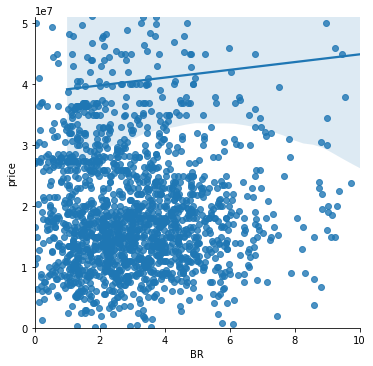

In [93]:
#plot graph for Price, BR and Bth
a_plot = sb.lmplot(x='BR',y='price',data=df, fit_reg=True, x_jitter= 1.0, y_jitter=0.1)
a_plot.set(xlim=(0, 10))
a_plot.set(ylim=(0, 51000000))

In [13]:
#checking df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1848 entries, 0 to 2132
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Address  1848 non-null   object 
 1   price    1848 non-null   float64
 2   Region   1848 non-null   int64  
 3   BR       1848 non-null   float64
 4   BTH      1848 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 86.6+ KB


In [14]:
#changing Region's data type to a float for modelling
df['Region'] = df['Region'].astype('float')
df

,Address,price,Region,BR,BTH
0,7.5 LOMBARD CLOSE,527587.0,6.0,3.0,2.0
8,221 RUBY WAY,8500000.0,13.0,1.0,2.0
10,GOLDEN SPRING/MT FRIEND,9000000.0,9.0,5.0,2.0
18,10-1A DUQUESNAY AVE,10500000.0,10.0,1.0,1.0
19,APT5-21 MERRICK HIGHWAY,10800000.0,19.0,1.0,1.0
...,...,...,...,...,...
2128,14 CYPRESS HALL ROAD,24000000.0,21.0,4.0,3.0
2129,"31PARL ROAD, BELLA VISTA",24000000.0,19.0,4.0,3.0
2130,FAIRLANE DRIVE,24000000.0,10.0,4.0,2.0
2131,30 BEACH CLOSE,24000000.0,17.0,5.0,6.0


#### Visualize data:

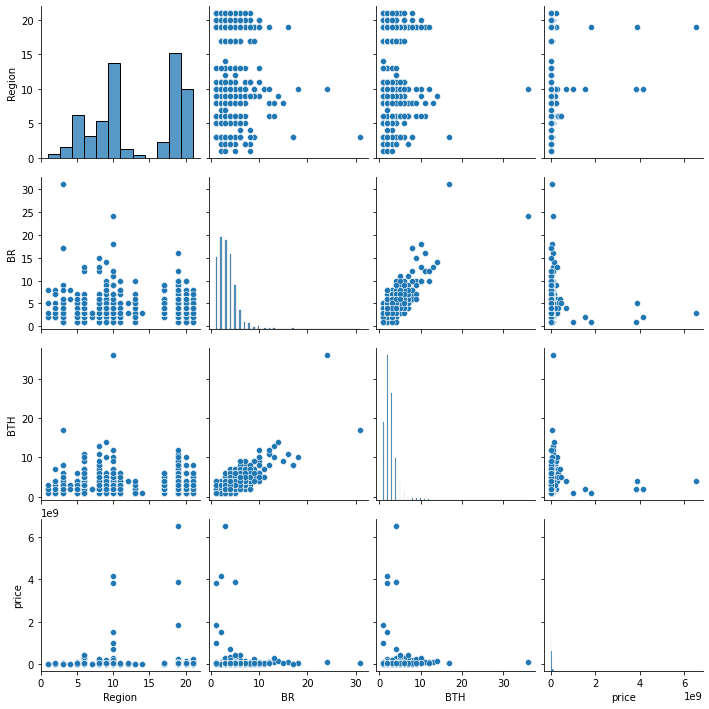

In [15]:
#plot data to visualize distribution
sb.pairplot(df[['Region', 'BR', 'BTH', 'price']]);

I can see a correlation between no. of beds and no. of baths but my dependent variable, price, doesn't show any initial correlation with the other features.

In [137]:
#create linear regression model
df['intercept'] = 1

lm = sm.OLS(df['price'], df[['intercept', 'Region', 'BR', 'BTH']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     6.715
Date:                Sun, 11 Jul 2021   Prob (F-statistic):           0.000167
Time:                        19:04:39   Log-Likelihood:                -38189.
No. Observations:                1848   AIC:                         7.639e+04
Df Residuals:                    1844   BIC:                         7.641e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.857e+07   1.49e+07      1.919      0.055   -6.34e+05    5.78e+07
Region     -2.262e+05   9.19e+05     -0.246      0.806   -2.03e+06    1.58e+06
BR         -1.315e+07    4.1e+06     -3.207      0.001   -2.12e+07   -5.11e+06
BTH         2.154e+07   4.89e+06      4.402      0.000    1.19e+07    3.11e+07
==============================================================================
Omnibus:                     4175.832   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18107368.862
Skew:                          20.777   Prob(JB):                         0.00
Kurtosis:                     486.150   Cond. No.                         42.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Define x and y:

In [16]:
factors = ['Region', 'BR', 'BTH']
x=df[factors].values
y=df['price'].values

In [17]:
print(x)
print(y)

[[ 6.  3.  2.]
 [13.  1.  2.]
 [ 9.  5.  2.]
 ...
 [10.  4.  2.]
 [17.  5.  6.]
 [17.  4.  4.]]
[  527587.  8500000.  9000000. ... 24000000. 24000000. 24000000.]


## Split data into train and test models 

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=0, test_size=0.1)

## Train model
### Decision Tree:

In [131]:
from sklearn.tree import DecisionTreeRegressor
model=DecisionTreeRegressor(max_leaf_nodes=50)
model.fit(x_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=50)

## Predict test results

In [132]:
y_pred = model.predict(x_test)

In [111]:
model.predict([[6,3.0,2.0]])

array([527587.])

In [133]:
mean_absolute_error(y_test, y_pred)

21174767.158942625

In [125]:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [138]:
for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, x_train, x_test, y_train, y_test)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:  22013543
Max leaf nodes: 50  		 Mean Absolute Error:  21174767
Max leaf nodes: 500  		 Mean Absolute Error:  21380513
Max leaf nodes: 5000  		 Mean Absolute Error:  21380513


### Random Forest:

In [134]:
from sklearn.ensemble import RandomForestRegressor

In [136]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(x_train, y_train)
preds = forest_model.predict(x_test)
mae = mean_absolute_error(y_test, preds)
get_mae(50, x_train, x_test, y_train, y_test)

21174767.158942625